In [5]:
import pandas as pd
import json
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from flask import Flask, request, jsonify
from sklearn.utils import resample

In [8]:

# Initialize an empty list to hold the data
data = []

# Load JSON data line by line
with open('/Users/kundansingh/Desktop/untitledfolder/DL/DL3/yelp_academic_dataset_business.json', 'r') as file:
    for line in file:
        data.append(json.loads(line))

# Convert to DataFrame
df = pd.DataFrame(data)


#Handling the imbalance between the two prdiction classes(0,1 = open parking, closed parking)
target_column = 'is_open'  

# Step 1: Find the smallest class size
min_count = df[target_column].value_counts().min()

# Step 2: Downsample each class to have the same number of samples
balanced_data = [
    resample(df[df[target_column] == label], 
             n_samples=min_count, 
             random_state=42)
    for label in df[target_column].unique()
]

# Step 3: Combine all balanced classes into a single DataFrame
df = pd.concat(balanced_data).sample(frac=1, random_state=42).reset_index(drop=True)




# Preprocessing steps
# 1. Handle missing values
df.fillna({'hours': 'N/A'}, inplace=True)  # Fill NaN values in 'hours'


# 2. Convert categorical columns to numeric
df['is_open'] = df['is_open'].astype(int)

# 3. Create binary target variable for parking availability
# (Assuming 'is_open' represents parking availability for simplicity)
df['parking_availability'] = df['is_open']

# 4. Select relevant features
features = ['latitude', 'longitude']
X = df[features]
y = df[ 'is_open']

# 5. Split into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Save preprocessed data for model training
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

print("Preprocessing completed. Data saved.")

Preprocessing completed. Data saved.


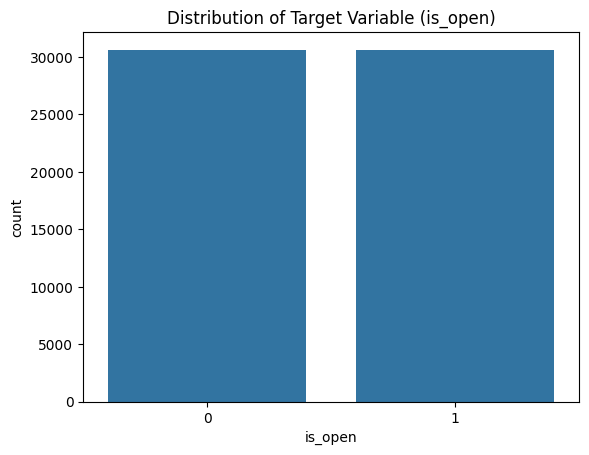

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=y)
plt.title('Distribution of Target Variable (is_open)')
plt.show()

In [26]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Load preprocessed data
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv').values.ravel()  # Flatten to 1D array
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv').values.ravel()

# Train the model
model = XGBClassifier( eval_metric='logloss', max_depth=10, n_estimators=500)
model.fit(X_train, y_train)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [27]:
X_train

,latitude,longitude
0,39.771895,-86.158285
1,40.027860,-75.330685
2,34.422028,-119.600943
3,40.036347,-74.825416
4,39.474055,-119.782213
...,...,...
49031,34.418727,-119.699102
49032,53.467706,-113.580028
49033,39.488950,-119.793719
49034,34.421825,-119.703380


In [31]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Get the predicted probabilities for the positive class

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

# Display the results
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')


Accuracy: 0.60
Precision: 0.61
Recall: 0.56
F1 Score: 0.58
ROC AUC: 0.63


In [32]:
# Generate classification report
report = classification_report(y_test, y_pred, target_names=["Class 0", "Class 1"])
print(report)

              precision    recall  f1-score   support

     Class 0       0.59      0.63      0.61      6109
     Class 1       0.61      0.56      0.58      6151

    accuracy                           0.60     12260
   macro avg       0.60      0.60      0.60     12260
weighted avg       0.60      0.60      0.60     12260



In [30]:
import joblib
joblib.dump(model, 'x06.joblib')
print("Model Saved")

Model Saved
